In [1]:
import os
import csv
import pandas as pd
import numpy as np

In [2]:
dataset_names=[]
X_trains=[]
y_trains=[]
X_tests=[]

path = "C:/Users/User/Desktop/SeniorYearFirstSem/DataScience/Competition1_code/Competition_data"
for folder_name in os.listdir(path):
    print(folder_name)
    dataset_names.append(folder_name)
    X_trains.append(pd.read_csv(f"{path}/{folder_name}/X_train.csv", header=0))
    y_trains.append(pd.read_csv(f"{path}/{folder_name}/y_train.csv", header=0))
    X_tests.append(pd.read_csv(f"{path}/{folder_name}/X_test.csv", header=0))

Dataset_1
Dataset_10
Dataset_11
Dataset_12
Dataset_13
Dataset_14
Dataset_15
Dataset_16
Dataset_17
Dataset_18
Dataset_19
Dataset_2
Dataset_20
Dataset_21
Dataset_22
Dataset_23
Dataset_24
Dataset_25
Dataset_26
Dataset_27
Dataset_28
Dataset_29
Dataset_3
Dataset_30
Dataset_31
Dataset_32
Dataset_33
Dataset_34
Dataset_35
Dataset_36
Dataset_37
Dataset_38
Dataset_39
Dataset_4
Dataset_40
Dataset_41
Dataset_42
Dataset_43
Dataset_44
Dataset_45
Dataset_46
Dataset_47
Dataset_48
Dataset_49
Dataset_5
Dataset_6
Dataset_7
Dataset_8
Dataset_9


In [3]:
## Train & Test & Split & Build Model
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


In [4]:
### Preprocessing
def remove_outlier(df, lower_quantile=0.25, upper_quantile=0.75, iqr_multiplier=1.5):
    """
    去除數值型特徵中的異常值（基於 IQR）。
    """
    numeric_cols = df.select_dtypes(include=['float64', 'int64'])
    for col in numeric_cols.columns:
        Q1 = df[col].quantile(lower_quantile)
        Q3 = df[col].quantile(upper_quantile)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
        df[col] = np.clip(df[col], lower_bound, upper_bound)  # 將異常值剪裁到合理範圍
    return df

from sklearn.feature_selection import VarianceThreshold

def remove_low_variance(df, threshold=0.0001):
    """
    移除方差低於 threshold 的特徵。
    """
    selector = VarianceThreshold(threshold=threshold)
    numeric_data = df.select_dtypes(include=['float64', 'int64'])
    high_variance_data = selector.fit_transform(numeric_data)
    retained_features = numeric_data.columns[selector.get_support()]
    df = df[retained_features]
    return df

from scipy.stats import boxcox

def adjust_skewness(df, skew_threshold=2):
    """
    調整偏態，對偏度高於指定閾值的數值型特徵進行處理。
    """
    numeric_cols = df.select_dtypes(include=['float64', 'int64'])
    for col in numeric_cols.columns:
        skewness = df[col].skew()
        if skewness > skew_threshold:  # 偏態較高
            if (df[col] > 0).all():  # Box-Cox 要求數據為正數
                df[col], _ = boxcox(df[col] + 1e-6)
            else:  # 含有非正數，則使用 log1p
                df[col] = np.log1p(df[col] - df[col].min() + 1e-6)
    return df

def select_important_features(X, y, importance_threshold=0.005, retained_top_fraction=0.8):
    """
    基於特徵重要性選擇相關特徵，支持保留累計重要性占前 retained_top_fraction 的特徵。
    """
    # 確保 X 是 DataFrame 格式
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)

    # 定義模型
    model = AdaBoostClassifier(
                n_estimators=50,
                learning_rate=1,
                algorithm='SAMME',
                random_state=1
            )
    # 訓練模型
    model.fit(X, y)

    # 獲取特徵重要性並排序
    feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

    # 根據 importance_threshold 選擇初步篩選的特徵
    selected_features = feature_importances[feature_importances > importance_threshold].index.tolist()

    # 檢查篩選後的特徵數量
    if len(selected_features) < int(len(feature_importances) * retained_top_fraction):
        # 如果刪除的特徵過多，保留重要性最高的特徵
        num_to_retain = int(len(feature_importances) * retained_top_fraction)
        top_features = feature_importances.nlargest(num_to_retain).index.tolist()
        selected_features = list(set(selected_features + top_features))  # 合併去重
        print(f"Retained top {retained_top_fraction*100:.0f}% of features based on importance.")

    # 選擇重要特徵
    X_selected = X[selected_features]

    print(f"Selected {len(selected_features)} important features out of {X.shape[1]}. "
        f"(retained_top_fraction={retained_top_fraction}, importance_threshold={importance_threshold})")


    return X_selected, selected_features

from imblearn.over_sampling import SMOTE, ADASYN

def handle_class_imbalance(X, y, method='smote'):
    """
    使用 SMOTE 或 ADASYN 處理類別不平衡。
    """
    if method == 'smote':
        sampler = SMOTE(random_state=42)
    elif method == 'adasyn':
        sampler = ADASYN(random_state=42)
    else:
        raise ValueError(f"Unsupported imbalance method: {method}")
    
    X_resampled, y_resampled = sampler.fit_resample(X, y)
    print(f"Class imbalance handled: {dict(pd.Series(y_resampled).value_counts())}")
    return X_resampled, y_resampled


In [5]:
from sklearn.preprocessing import OneHotEncoder
def preprocess_pipeline(X, y=None, imbalance_method='smote', selected_features=None, encoder=None, lower_quantile=0.25, upper_quantile=0.75):
    """
    預處理流水線：分離數值和類別特徵，進行數據清理、特徵選擇以及類別不平衡處理。
    """
    print("Starting preprocessing pipeline...")

    # 分離數值型和類別型特徵
    numeric_features = X.select_dtypes(include=['float64', 'int64'])
    categorical_features = X.select_dtypes(include=['object', 'category'])

    # 測試階段
    if y is None:
        print("Testing stage: Applying pre-selected features and encoder...")

        # 驗證必要參數
        if selected_features is None:
            raise ValueError("Testing stage requires selected_features.")
        if categorical_features.shape[1] > 0 and encoder is None:
            raise ValueError("Testing stage requires encoder when categorical features are present.")

        # 處理類別型特徵（如果存在）
        if categorical_features.shape[1] > 0:
            if encoder is None:
                raise ValueError("Encoder is None during testing stage, but categorical features are present.")
            X_categorical = encoder.transform(categorical_features)
        else:
            X_categorical = np.empty((X.shape[0], 0))  # 空數組

        # 數值型特徵
        X_numeric = numeric_features.values  # 轉換為 NumPy

        # 合併數值型和類別型特徵
        X_combined = np.hstack([X_numeric, X_categorical])

        # 應用選擇的特徵
        if isinstance(selected_features[0], str):  # 如果選擇的特徵是列名
            all_feature_names = list(numeric_features.columns)
            if categorical_features.shape[1] > 0:
                all_feature_names += encoder.get_feature_names_out(categorical_features.columns).tolist()
            feature_indices = [all_feature_names.index(feat) for feat in selected_features]
            X_combined = X_combined[:, feature_indices]
        else:  # 如果選擇的特徵是索引
            X_combined = X_combined[:, selected_features]

        print(f"Testing stage: Final dataset shape after applying selected features: {X_combined.shape}")
        return X_combined, None, selected_features, encoder


    # 訓練階段執行完整預處理
    print("Training stage: Performing full preprocessing...")

    # Step 1: Process numeric features
    X_numeric = numeric_features.copy()
    X_numeric = remove_outlier(X_numeric, lower_quantile, upper_quantile)
    X_numeric = remove_low_variance(X_numeric)
    X_numeric = adjust_skewness(X_numeric)

    # Step 2: Process categorical features (One-hot encoding)
    if categorical_features.shape[1] > 0:
        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        X_categorical = encoder.fit_transform(categorical_features)
        categorical_feature_names = encoder.get_feature_names_out(categorical_features.columns)
    else:
        encoder = None
        X_categorical = np.empty((X_numeric.shape[0], 0))  # 空數組
        categorical_feature_names = []

    # Combine numeric and categorical features
    X_combined = np.hstack([X_numeric, X_categorical])
    all_feature_names = list(X_numeric.columns) + list(categorical_feature_names)

    # 修正特徵名稱長度
    if len(all_feature_names) > X_combined.shape[1]:
        all_feature_names = all_feature_names[:X_combined.shape[1]]

    X_combined = pd.DataFrame(X_combined, columns=all_feature_names)
    print(f"Combined dataset shape: {X_combined.shape}")

    # Step 3: Select important features
    X_combined, selected_features = select_important_features(X_combined, y)
    print(f"Selected features: {selected_features}")

    # Step 4: Handle class imbalance
    X_final, y_final = handle_class_imbalance(X_combined, y, method=imbalance_method)

    # 確保數據格式一致
    if isinstance(X_final, np.ndarray):
        X_final = pd.DataFrame(X_final, columns=selected_features)

    print(f"Final dataset shape: {X_final.shape}")
    print("Preprocessing pipeline completed.")
    return X_final, y_final, selected_features, encoder


In [6]:
average_auc = 0
y_predicts = []

for i in range(len(dataset_names)):

   # 獲取當前數據集的特徵和標籤
    X_sample = X_trains[i]  # 保持 pandas DataFrame 格式
    y_sample = y_trains[i].values.ravel() 
    X_test = X_tests[i]  # 測試數據
    
    # 数据预处理，训练阶段执行特征选择
    X_sample, y_sample, selected_features, encoder = preprocess_pipeline(
        X_sample,
        y_sample,
        imbalance_method='smote'
    )

    # 预处理测试数据，严格同步训练阶段的特征选择和编码
    X_test_processed, _, _, _ = preprocess_pipeline(
        X_test,
        selected_features=selected_features,  # 使用已选定的特征
        encoder=encoder,  # 使用训练阶段的编码器
    )
    
    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(X_sample, y_sample, train_size=0.6, random_state=123)
    
    # Train the Gradient Boosting model
    model = AdaBoostClassifier(
                n_estimators=50,
                learning_rate=1,
                algorithm='SAMME',
                random_state=1
            )
    
    model.fit(X_train, y_train)
    
    # 验证集预测
    y_val_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_proba)
    average_auc += auc

    print(f"Dataset {dataset_names[i]} Validation AUC: {auc:.4f}")

    # 生成测试集预测概率
    y_test_proba = model.predict_proba(X_test_processed)[:, 1]
    y_predicts.append(pd.DataFrame(y_test_proba, columns=['y_predict_proba']))

    # 保存到对应路径
    output_dir = os.path.join(path, dataset_names[i])  # 根据主路径和数据集名称生成路径
    os.makedirs(output_dir, exist_ok=True)
    y_predicts[-1].to_csv(os.path.join(output_dir, "y_predict.csv"), index=False)

# Average AUC across datasets
average_auc /= len(dataset_names)
print(f"Average AUC = {average_auc:.4f}")

Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Removed 0 low-variance features.
Adjusted skewness for 3 features.
Combined dataset shape: (444, 20)
Selecting important features using GradientBoostingClassifier...
Retained top 80% of features based on importance.
Selected 16 important features out of 20.
Selected features: [11 10  9  8 14 18 17 16  5  3  6 15 19  1  7  0]
Final dataset shape: (626, 16)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (296, 16)
Dataset Dataset_1 Validation AUC: 0.8890
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Removed 0 low-variance features.
Adjusted skewness for 1 features.
Combined dataset shape: (467, 11)
Selecting important features using GradientBoostingClassifier...
Selected 8 important features out of 11.
Selected features

In [13]:
average_auc = 0
y_predicts = []

for i in range(len(dataset_names)):

    # 獲取當前數據集的特徵和標籤
    X_sample = X_trains[i]  # 保持 pandas DataFrame 格式
    y_sample = y_trains[i].values.ravel()
    X_test = X_tests[i]  # 測試數據

    # 定義模型
    model = AdaBoostClassifier(
                n_estimators=50,
                learning_rate=1,
                algorithm='SAMME',
                random_state=1
            )

    # Step 1: 測試未經預處理的性能
    X_train, X_val, y_train, y_val = train_test_split(X_sample, y_sample, train_size=0.6, random_state=123)
    model.fit(X_train, y_train)
    y_val_proba_raw = model.predict_proba(X_val)[:, 1]
    auc_raw = roc_auc_score(y_val, y_val_proba_raw)

    print(f"Dataset {dataset_names[i]} Raw Validation AUC: {auc_raw:.4f}")

    # 如果未經預處理的 AUC 已經達到 100，則跳過預處理
    if auc_raw >= 1.0:
        print(f"Dataset {dataset_names[i]} reached perfect AUC without preprocessing. Skipping preprocessing.")
        X_test_processed = X_test
    else:
        # Step 2: 預處理數據
        X_sample_preprocessed, y_sample_preprocessed, selected_features, encoder = preprocess_pipeline(
            X_sample,
            y_sample,
            imbalance_method='smote'
        )

        # 预处理测试数据
        X_test_processed, _, _, _ = preprocess_pipeline(
            X_test,
            selected_features=selected_features,
            encoder=encoder,
        )

        # Step 3: 測試經過預處理的性能
        X_train_preprocessed, X_val_preprocessed, y_train_preprocessed, y_val_preprocessed = train_test_split(
            X_sample_preprocessed, y_sample_preprocessed, train_size=0.6, random_state=123
        )
        model.fit(X_train_preprocessed, y_train_preprocessed)
        y_val_proba_preprocessed = model.predict_proba(X_val_preprocessed)[:, 1]
        auc_preprocessed = roc_auc_score(y_val_preprocessed, y_val_proba_preprocessed)

        print(f"Dataset {dataset_names[i]} Preprocessed Validation AUC: {auc_preprocessed:.4f}")

        # 選擇較高性能的數據集
        if auc_preprocessed > auc_raw:
            print(f"Using preprocessed data for Dataset {dataset_names[i]}.")
            X_sample, y_sample = X_sample_preprocessed, y_sample_preprocessed
        else:
            print(f"Using raw data for Dataset {dataset_names[i]}.")
            X_test_processed = X_test  # 如果原始數據表現更好

    # Step 4: 最終模型訓練和測試
    model.fit(X_sample, y_sample)
    y_test_proba = model.predict_proba(X_test_processed)[:, 1]
    y_predicts.append(pd.DataFrame(y_test_proba, columns=['y_predict_proba']))

    # 保存到对应路径
    output_dir = os.path.join(path, dataset_names[i])
    os.makedirs(output_dir, exist_ok=True)
    y_predicts[-1].to_csv(os.path.join(output_dir, "y_predict.csv"), index=False)

    # 更新 AUC 統計
    average_auc += max(auc_raw, auc_preprocessed) if 'auc_preprocessed' in locals() else auc_raw

# Average AUC across datasets
average_auc /= len(dataset_names)
print(f"Average AUC = {average_auc:.4f}")

Dataset Dataset_1 Raw Validation AUC: 0.8238
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (444, 17)
Retained top 80% of features based on importance.
Selected 13 important features out of 17. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_4', 'Feature_6', 'Feature_8', 'Feature_11', 'Feature_20', 'Feature_1', 'Feature_9', 'Feature_3', 'Feature_16', 'Feature_10', 'Feature_5', 'Feature_7', 'Feature_2']
Class imbalance handled: {0: np.int64(313), 1: np.int64(313)}
Final dataset shape: (626, 13)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (296, 13)
Dataset Dataset_1 Preprocessed Validation AUC: 0.8797
Using preprocessed data for Dataset Dataset_1.


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_10 Raw Validation AUC: 0.7239
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (467, 9)
Selected 8 important features out of 9. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_4', 'Feature_7', 'Feature_1', 'Feature_5', 'Feature_2', 'Feature_6', 'Feature_10', 'Feature_8']
Class imbalance handled: {0: np.int64(273), 1: np.int64(273)}
Final dataset shape: (546, 8)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (312, 8)
Dataset Dataset_10 Preprocessed Validation AUC: 0.7954
Using preprocessed data for Dataset Dataset_10.


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_11 Raw Validation AUC: 0.5966
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (58, 62)
Retained top 80% of features based on importance.
Selected 49 important features out of 62. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_28', 'Feature_27', 'Feature_8', 'Feature_15', 'Feature_11', 'Feature_24', 'Feature_32', 'Feature_19', 'Feature_61', 'Feature_43', 'Feature_40', 'Feature_23', 'Feature_7', 'Feature_12', 'Feature_6', 'Feature_58', 'Feature_45', 'Feature_18', 'Feature_3', 'Feature_49', 'Feature_46', 'Feature_17', 'Feature_14', 'Feature_39', 'Feature_53', 'Feature_20', 'Feature_1', 'Feature_26', 'Feature_9', 'Feature_30', 'Feature_44', 'Feature_42', 'Feature_41', 'Feature_10', 'Feature_5', 'Feature_21', 'Feature_51', 'Feature_2', 'Feature_4', 'Feature_31', 'Feature_56', 'Feature_52', 'Feature_37', 'Feature_25', 'Feature_62', 'Feature_29', 'Feature_22', 'Feature_13', 'Featu

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_12 Preprocessed Validation AUC: 0.9612
Using preprocessed data for Dataset Dataset_12.
Dataset Dataset_13 Raw Validation AUC: 0.8903
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (181, 34)


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Retained top 80% of features based on importance.
Selected 27 important features out of 34. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_27', 'Feature_8', 'Feature_15', 'Feature_11', 'Feature_19', 'Feature_32', 'Feature_7', 'Feature_6', 'Feature_18', 'Feature_3', 'Feature_17', 'Feature_34', 'Feature_14', 'Feature_54', 'Feature_20', 'Feature_1', 'Feature_33', 'Feature_9', 'Feature_42', 'Feature_10', 'Feature_5', 'Feature_21', 'Feature_2', 'Feature_4', 'Feature_31', 'Feature_22', 'Feature_13']
Class imbalance handled: {0: np.int64(129), 1: np.int64(129)}
Final dataset shape: (258, 27)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (122, 27)
Dataset Dataset_13 Preprocessed Validation AUC: 0.9727
Using preprocessed data for Dataset Dataset_13.


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_14 Raw Validation AUC: 1.0000
Dataset Dataset_14 reached perfect AUC without preprocessing. Skipping preprocessing.
Dataset Dataset_15 Raw Validation AUC: 0.7068
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (368, 6)
Selected 4 important features out of 6. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_2', 'Feature_3', 'Feature_11', 'Feature_1']
Class imbalance handled: {0: np.int64(250), 1: np.int64(250)}
Final dataset shape: (500, 4)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (246, 4)
Dataset Dataset_15 Preprocessed Validation AUC: 0.5597
Using raw data for Dataset Dataset_15.
Dataset Dataset_16 Raw Validation AUC: 0.9979
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dat

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_17 Raw Validation AUC: 0.9418
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (120, 19)
Selected 15 important features out of 19. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_5', 'Feature_4', 'Feature_10', 'Feature_15', 'Feature_13', 'Feature_19', 'Feature_2', 'Feature_8', 'Feature_6', 'Feature_7', 'Feature_12', 'Feature_14', 'Feature_1', 'Feature_18', 'Feature_3']
Class imbalance handled: {1.0: np.int64(63), 0.0: np.int64(63)}
Final dataset shape: (126, 15)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (81, 15)
Dataset Dataset_17 Preprocessed Validation AUC: 0.8448
Using raw data for Dataset Dataset_17.
Dataset Dataset_18 Raw Validation AUC: 1.0000
Dataset Dataset_18 reached perfect AUC without preprocessing. Skipping pr

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_2 Raw Validation AUC: 0.9979
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (465, 13)
Retained top 80% of features based on importance.
Selected 10 important features out of 13. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_12', 'Feature_8', 'Feature_24', 'Feature_20', 'Feature_1', 'Feature_3', 'Feature_19', 'Feature_5', 'Feature_7', 'Feature_2']
Class imbalance handled: {1: np.int64(287), 0: np.int64(287)}
Final dataset shape: (574, 10)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (311, 10)
Dataset Dataset_2 Preprocessed Validation AUC: 0.9984
Using preprocessed data for Dataset Dataset_2.
Dataset Dataset_20 Raw Validation AUC: 0.8740
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Co

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Retained top 80% of features based on importance.
Selected 10 important features out of 13. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_4', 'Feature_12', 'Feature_6', 'Feature_1', 'Feature_9', 'Feature_3', 'Feature_13', 'Feature_5', 'Feature_7', 'Feature_2']
Class imbalance handled: {0: np.int64(91), 1: np.int64(91)}
Final dataset shape: (182, 10)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (86, 10)
Dataset Dataset_20 Preprocessed Validation AUC: 0.9432
Using preprocessed data for Dataset Dataset_20.


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_21 Raw Validation AUC: 0.9310
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (303, 17)
Selected 14 important features out of 17. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_10', 'Feature_12', 'Feature_11', 'Feature_2', 'Feature_3', 'Feature_9', 'Feature_8', 'Feature_13', 'Feature_6', 'Feature_4', 'Feature_16', 'Feature_14', 'Feature_17', 'Feature_1']
Class imbalance handled: {1.0: np.int64(175), 0.0: np.int64(175)}
Final dataset shape: (350, 14)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (203, 14)
Dataset Dataset_21 Preprocessed Validation AUC: 0.9702
Using preprocessed data for Dataset Dataset_21.


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_22 Raw Validation AUC: 0.8559
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (128, 7)
Selected 7 important features out of 7. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_7', 'Feature_6', 'Feature_5', 'Feature_4', 'Feature_9', 'Feature_3', 'Feature_2']
Class imbalance handled: {0: np.int64(81), 1: np.int64(81)}
Final dataset shape: (162, 7)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (86, 7)
Dataset Dataset_22 Preprocessed Validation AUC: 0.8929
Using preprocessed data for Dataset Dataset_22.


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_23 Raw Validation AUC: 0.9422
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (354, 14)
Selected 11 important features out of 14. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_2', 'Feature_12', 'Feature_5', 'Feature_10', 'Feature_6', 'Feature_1', 'Feature_4', 'Feature_3', 'Feature_9', 'Feature_8', 'Feature_13']
Class imbalance handled: {1: np.int64(217), 0: np.int64(217)}
Final dataset shape: (434, 11)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (236, 11)
Dataset Dataset_23 Preprocessed Validation AUC: 0.9523
Using preprocessed data for Dataset Dataset_23.


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_24 Raw Validation AUC: 0.6503
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (600, 10)
Retained top 80% of features based on importance.
Selected 8 important features out of 10. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_4', 'Feature_6', 'Feature_8', 'Feature_1', 'Feature_3', 'Feature_5', 'Feature_7', 'Feature_2']
Class imbalance handled: {0: np.int64(426), 1: np.int64(426)}
Final dataset shape: (852, 8)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (400, 8)
Dataset Dataset_24 Preprocessed Validation AUC: 0.7576
Using preprocessed data for Dataset Dataset_24.


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_25 Raw Validation AUC: 0.9618
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (135, 6)
Retained top 80% of features based on importance.
Selected 4 important features out of 6. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_2', 'Feature_6', 'Feature_3', 'Feature_1']
Class imbalance handled: {0: np.int64(87), 1: np.int64(87)}
Final dataset shape: (174, 4)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (90, 4)
Dataset Dataset_25 Preprocessed Validation AUC: 0.9826
Using preprocessed data for Dataset Dataset_25.


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_26 Raw Validation AUC: 0.7873
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (179, 22)
Retained top 80% of features based on importance.
Selected 17 important features out of 22. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_4', 'Feature_12', 'Feature_6', 'Feature_23', 'Feature_27', 'Feature_15', 'Feature_25', 'Feature_18', 'Feature_1', 'Feature_9', 'Feature_22', 'Feature_3', 'Feature_19', 'Feature_16', 'Feature_14', 'Feature_7', 'Feature_2']
Class imbalance handled: {0: np.int64(114), 1: np.int64(114)}
Final dataset shape: (228, 17)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (120, 17)
Dataset Dataset_26 Preprocessed Validation AUC: 0.9067
Using preprocessed data for Dataset Dataset_26.


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_27 Raw Validation AUC: 1.0000
Dataset Dataset_27 reached perfect AUC without preprocessing. Skipping preprocessing.
Dataset Dataset_28 Raw Validation AUC: 0.7951
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (460, 8)
Selected 8 important features out of 8. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_6', 'Feature_2', 'Feature_7', 'Feature_8', 'Feature_4', 'Feature_1', 'Feature_5', 'Feature_3']
Class imbalance handled: {1: np.int64(299), 0: np.int64(299)}
Final dataset shape: (598, 8)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (308, 8)
Dataset Dataset_28 Preprocessed Validation AUC: 0.8588
Using preprocessed data for Dataset Dataset_28.


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_29 Raw Validation AUC: 0.9577
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (306, 11)
Selected 10 important features out of 11. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_11', 'Feature_6', 'Feature_5', 'Feature_9', 'Feature_10', 'Feature_8', 'Feature_7', 'Feature_3', 'Feature_1', 'Feature_4']
Class imbalance handled: {0.0: np.int64(175), 1.0: np.int64(175)}
Final dataset shape: (350, 10)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (205, 10)
Dataset Dataset_29 Preprocessed Validation AUC: 0.9552
Using raw data for Dataset Dataset_29.
Dataset Dataset_3 Raw Validation AUC: 0.7653
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (69, 9)
Selected 8 important feat

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_30 Raw Validation AUC: 0.7276
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (553, 17)
Retained top 80% of features based on importance.
Selected 13 important features out of 17. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_4', 'Feature_12', 'Feature_6', 'Feature_8', 'Feature_11', 'Feature_1', 'Feature_9', 'Feature_26', 'Feature_3', 'Feature_10', 'Feature_5', 'Feature_7', 'Feature_2']
Class imbalance handled: {1: np.int64(355), 0: np.int64(355)}
Final dataset shape: (710, 13)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (370, 13)
Dataset Dataset_30 Preprocessed Validation AUC: 0.7816
Using preprocessed data for Dataset Dataset_30.
Dataset Dataset_31 Raw Validation AUC: 0.7650
Starting preprocessing pipeline...
Training 

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Selected 13 important features out of 13. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_1', 'Feature_3', 'Feature_8', 'Feature_15', 'Feature_9', 'Feature_5', 'Feature_6', 'Feature_11', 'Feature_2', 'Feature_4', 'Feature_14', 'Feature_7', 'Feature_10']
Class imbalance handled: {0: np.int64(59), 1: np.int64(59)}
Final dataset shape: (118, 13)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (54, 13)
Dataset Dataset_31 Preprocessed Validation AUC: 0.9003
Using preprocessed data for Dataset Dataset_31.


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_32 Raw Validation AUC: 0.7388
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (593, 3)
Selected 2 important features out of 3. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_1', 'Feature_3']
Class imbalance handled: {1: np.int64(506), 0: np.int64(506)}
Final dataset shape: (1012, 2)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (396, 2)
Dataset Dataset_32 Preprocessed Validation AUC: 0.7909
Using preprocessed data for Dataset Dataset_32.


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_33 Raw Validation AUC: 0.9963
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (240, 11)
Selected 9 important features out of 11. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_1', 'Feature_6', 'Feature_4', 'Feature_11', 'Feature_9', 'Feature_3', 'Feature_10', 'Feature_2', 'Feature_5']
Class imbalance handled: {0: np.int64(152), 1: np.int64(152)}
Final dataset shape: (304, 9)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (160, 9)
Dataset Dataset_33 Preprocessed Validation AUC: 0.9887
Using raw data for Dataset Dataset_33.
Dataset Dataset_34 Raw Validation AUC: 0.8531
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (274, 11)
Selected 11 important features out of 11. 

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_35 Raw Validation AUC: 0.7938
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (460, 8)
Selected 6 important features out of 8. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_2', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_1', 'Feature_3']
Class imbalance handled: {1: np.int64(299), 0: np.int64(299)}
Final dataset shape: (598, 6)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (308, 6)
Dataset Dataset_35 Preprocessed Validation AUC: 0.8285
Using preprocessed data for Dataset Dataset_35.


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_36 Raw Validation AUC: 1.0000
Dataset Dataset_36 reached perfect AUC without preprocessing. Skipping preprocessing.
Dataset Dataset_37 Raw Validation AUC: 0.8812
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (177, 12)
Selected 10 important features out of 12. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_2', 'Feature_1', 'Feature_5', 'Feature_4', 'Feature_6', 'Feature_9', 'Feature_7', 'Feature_8', 'Feature_3', 'Feature_12']
Class imbalance handled: {1: np.int64(95), 0: np.int64(95)}
Final dataset shape: (190, 10)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (119, 10)
Dataset Dataset_37 Preprocessed Validation AUC: 0.8776
Using raw data for Dataset Dataset_37.
Dataset Dataset_38 Raw Validation AUC: 0.7455
Starting prepro

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_4 Raw Validation AUC: 0.5120
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (514, 6)
Selected 5 important features out of 6. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_3', 'Feature_1', 'Feature_9', 'Feature_4', 'Feature_8']
Class imbalance handled: {0: np.int64(486), 1: np.int64(486)}
Final dataset shape: (972, 5)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (344, 5)
Dataset Dataset_4 Preprocessed Validation AUC: 0.8636
Using preprocessed data for Dataset Dataset_4.


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_40 Raw Validation AUC: 0.7938
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (460, 8)
Selected 6 important features out of 8. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_2', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_1', 'Feature_3']
Class imbalance handled: {1: np.int64(299), 0: np.int64(299)}
Final dataset shape: (598, 6)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (308, 6)
Dataset Dataset_40 Preprocessed Validation AUC: 0.8285
Using preprocessed data for Dataset Dataset_40.


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_41 Raw Validation AUC: 0.9794
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (480, 10)
Selected 10 important features out of 10. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_5', 'Feature_1', 'Feature_7', 'Feature_6', 'Feature_10', 'Feature_8', 'Feature_4', 'Feature_9', 'Feature_3', 'Feature_2']
Class imbalance handled: {0: np.int64(432), 1: np.int64(432)}
Final dataset shape: (864, 10)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (321, 10)
Dataset Dataset_41 Preprocessed Validation AUC: 0.9963
Using preprocessed data for Dataset Dataset_41.


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_42 Raw Validation AUC: 0.9828
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (120, 6)
Selected 6 important features out of 6. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_6', 'Feature_4', 'Feature_5', 'Feature_3', 'Feature_2', 'Feature_1']
Class imbalance handled: {0: np.int64(62), 1: np.int64(62)}
Final dataset shape: (124, 6)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (80, 6)
Dataset Dataset_42 Preprocessed Validation AUC: 0.9828
Using raw data for Dataset Dataset_42.
Dataset Dataset_43 Raw Validation AUC: 0.7388
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (593, 3)
Selected 2 important features out of 3. (retained_top_fraction=0.8, importance_threshold=

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Selected 3 important features out of 4. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_2', 'Feature_3', 'Feature_1']
Class imbalance handled: {1: np.int64(43), 0: np.int64(43)}
Final dataset shape: (86, 3)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (40, 3)
Dataset Dataset_44 Preprocessed Validation AUC: 1.0000
Using preprocessed data for Dataset Dataset_44.
Dataset Dataset_45 Raw Validation AUC: 1.0000
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (158, 4)
Selected 3 important features out of 4. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_3', 'Feature_2', 'Feature_1']
Class imbalance handled: {1: np.int64(147), 0: np.int64(147)}
Final dataset shape: (294, 3)
Preprocessing pipeline completed.
St

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Combined dataset shape: (176, 8)
Selected 8 important features out of 8. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_3', 'Feature_6', 'Feature_13', 'Feature_2', 'Feature_9', 'Feature_1', 'Feature_7', 'Feature_8']
Class imbalance handled: {0.0: np.int64(107), 1.0: np.int64(107)}
Final dataset shape: (214, 8)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (118, 8)
Dataset Dataset_46 Preprocessed Validation AUC: 0.8443
Using raw data for Dataset Dataset_46.
Dataset Dataset_47 Raw Validation AUC: 0.7960
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (86, 75)
Retained top 80% of features based on importance.
Selected 60 important features out of 75. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_28', 'Fe

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_48 Raw Validation AUC: 1.0000
Dataset Dataset_48 reached perfect AUC without preprocessing. Skipping preprocessing.
Dataset Dataset_49 Raw Validation AUC: 0.9842
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (575, 38)
Retained top 80% of features based on importance.
Selected 30 important features out of 38. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_27', 'Feature_8', 'Feature_15', 'Feature_11', 'Feature_19', 'Feature_35', 'Feature_7', 'Feature_23', 'Feature_12', 'Feature_6', 'Feature_3', 'Feature_17', 'Feature_14', 'Feature_34', 'Feature_39', 'Feature_20', 'Feature_1', 'Feature_26', 'Feature_9', 'Feature_41', 'Feature_5', 'Feature_10', 'Feature_21', 'Feature_2', 'Feature_4', 'Feature_25', 'Feature_37', 'Feature_29', 'Feature_22', 'Feature_16']
Class imbalance handled: {0: np.int64(368), 1: np.int64(368)}
Final dataset shape: (736, 30)
Preprocessing pipeline completed

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_5 Raw Validation AUC: 0.9057
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (324, 19)
Selected 16 important features out of 19. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_3', 'Feature_2', 'Feature_13', 'Feature_16', 'Feature_6', 'Feature_15', 'Feature_14', 'Feature_17', 'Feature_12', 'Feature_11', 'Feature_1', 'Feature_4', 'Feature_5', 'Feature_18', 'Feature_7', 'Feature_10']
Class imbalance handled: {0: np.int64(303), 1: np.int64(303)}
Final dataset shape: (606, 16)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (216, 16)
Dataset Dataset_5 Preprocessed Validation AUC: 0.9787
Using preprocessed data for Dataset Dataset_5.
Dataset Dataset_6 Raw Validation AUC: 0.9771
Starting preprocessing pipeline...
Training stage: Per

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Retained top 80% of features based on importance.
Selected 11 important features out of 14. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_4', 'Feature_6', 'Feature_11', 'Feature_1', 'Feature_9', 'Feature_3', 'Feature_13', 'Feature_10', 'Feature_5', 'Feature_7', 'Feature_2']
Class imbalance handled: {1: np.int64(188), 0: np.int64(188)}
Final dataset shape: (376, 11)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (208, 11)
Dataset Dataset_6 Preprocessed Validation AUC: 0.9883
Using preprocessed data for Dataset Dataset_6.
Dataset Dataset_7 Raw Validation AUC: 0.9656
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Combined dataset shape: (369, 12)
Selected 11 important features out of 12. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_3', 'Feature_5', 'Feature_10', 'Feature_4', 'Feature_8', 'Feature_2', 'Feature_6', 'Feature_11', 'Feature_1', 'Feature_9', 'Feature_7']
Class imbalance handled: {1: np.int64(321), 0: np.int64(321)}
Final dataset shape: (642, 11)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (246, 11)
Dataset Dataset_7 Preprocessed Validation AUC: 0.9976
Using preprocessed data for Dataset Dataset_7.


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_8 Raw Validation AUC: 0.8093
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (179, 12)
Retained top 80% of features based on importance.
Selected 9 important features out of 12. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_4', 'Feature_6', 'Feature_8', 'Feature_11', 'Feature_1', 'Feature_3', 'Feature_5', 'Feature_7', 'Feature_2']
Class imbalance handled: {0: np.int64(121), 1: np.int64(121)}
Final dataset shape: (242, 9)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected features and encoder...
Testing stage: Final dataset shape after applying selected features: (120, 9)
Dataset Dataset_8 Preprocessed Validation AUC: 0.9377
Using preprocessed data for Dataset Dataset_8.


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Dataset Dataset_9 Raw Validation AUC: 0.9164
Starting preprocessing pipeline...
Training stage: Performing full preprocessing...
Combined dataset shape: (144, 43)
Retained top 80% of features based on importance.
Selected 34 important features out of 43. (retained_top_fraction=0.8, importance_threshold=0.005)
Selected features: ['Feature_28', 'Feature_27', 'Feature_15', 'Feature_8', 'Feature_11', 'Feature_24', 'Feature_19', 'Feature_35', 'Feature_43', 'Feature_40', 'Feature_23', 'Feature_7', 'Feature_12', 'Feature_6', 'Feature_18', 'Feature_46', 'Feature_17', 'Feature_14', 'Feature_36', 'Feature_20', 'Feature_1', 'Feature_33', 'Feature_9', 'Feature_41', 'Feature_10', 'Feature_5', 'Feature_21', 'Feature_37', 'Feature_25', 'Feature_29', 'Feature_38', 'Feature_22', 'Feature_13', 'Feature_16']
Class imbalance handled: {1: np.int64(74), 0: np.int64(74)}
Final dataset shape: (148, 34)
Preprocessing pipeline completed.
Starting preprocessing pipeline...
Testing stage: Applying pre-selected fe

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


>>> Plot Graph

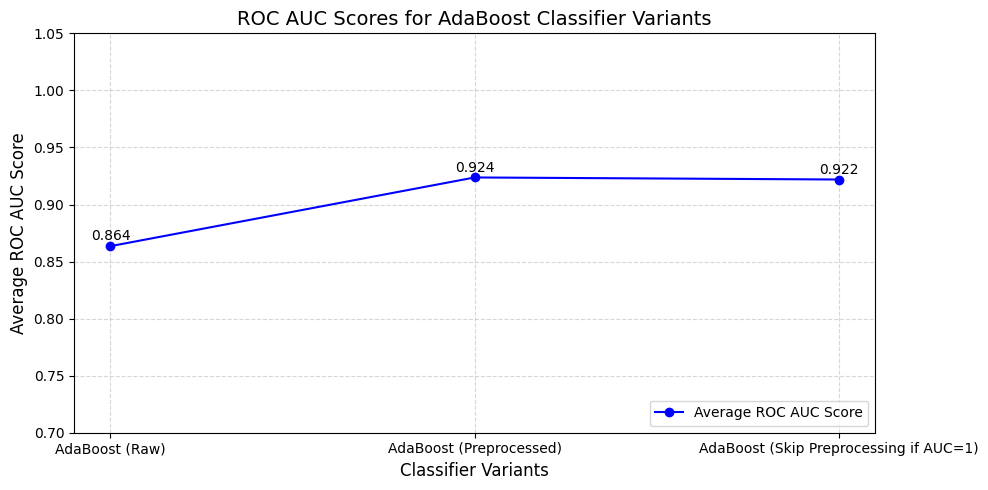

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# AUC_set values
AUC_set = [
    np.float64(0.8635),
    np.float64(0.9237),
    np.float64(0.9219),
]

classifiers = [
    "AdaBoost (Raw)",
    "AdaBoost (Preprocessed)",
    "AdaBoost (Skip Preprocessing if AUC=1)"
]

# Plotting the graph
plt.figure(figsize=(10, 5))
plt.plot(classifiers, AUC_set, marker='o', linestyle='-', color='b', label='Average ROC AUC Score')
#plt.xticks(rotation=30, ha='right', fontsize=10)  
plt.title('ROC AUC Scores for AdaBoost Classifier Variants', fontsize=14)  
plt.xlabel('Classifier Variants', fontsize=12)  
plt.ylabel('Average ROC AUC Score', fontsize=12)  
plt.grid(visible=True, linestyle='--', alpha=0.5)  
plt.ylim(0.7, 1.05)  
plt.legend(fontsize=10, loc='lower right')  

# Annotate data points with their corresponding AUC values
for i, value in enumerate(AUC_set):
    plt.text(i, value + 0.005, f"{value:.3f}", ha='center', fontsize=10)  # Display AUC values above the points

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
